# SMCN application for air quality predictions

In [3]:
import statsmodels.api as sm

In [4]:
import copy
import datetime
from pathlib import Path
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

from smcl.smcl import SMCL
from src.utils import plot_range, uncertainty_estimation, LitProgressBar, boxplotprediction
from oze.utils import plot_predictions, plot_daily_predictions
from src.metrics import pi_metrics, compute_cost
from oze.dataset import OzeDataset

# Set manual seeds
torch.manual_seed(1)
np.random.seed(1)

# Reload python packages when changed
%load_ext autoreload
%autoreload 2

# Matplotlib defaults
plt.rcParams.update({
    "font.size": 25,
    "figure.figsize": (25, 5)
})

# PyTorch Lightning loading bar
bar = LitProgressBar()

In [5]:
# Dataset
PATH_DATASET = "datasets/data_oze.csv"
T = 24*7

# Model
D_EMB = 8
N = 200

# Training
BATCH_SIZE = 16
EPOCHS = 100
EPOCHS_SMCN = 100

## Dataset

### Load and preprocess

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO

In [7]:
# Dataset
air2 = requests.get('https://www.stata-press.com/data/r12/air2.dta').content
data = pd.read_stata(BytesIO(air2))
data.index = pd.date_range(start=datetime(data.time[0], 1, 1), periods=len(data), freq='MS')
data['lnair'] = np.log(data['air'])

/tmp/ipykernel_73764/4245900923.py:4: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  data.index = pd.date_range(start=datetime(data.time[0], 1, 1), periods=len(data), freq='MS')


30

In [53]:
df = pd.read_csv(PATH_DATASET)[5*24:]
OzeDataset.preprocess(df)
# Restrict to october
# df = df[(datetime(year=2020, month=10, day=1) < df["datetime"] ) & (df["datetime"] < datetime(year=2020, month=11, day=1))]
df.sample(5)

/home/mrmojo/Code/these/smcl/oze/utils.py:60: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  occupancy = int(date < date_start_lockdown)
/home/mrmojo/Code/these/smcl/oze/utils.py:63: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if date_end_lockdown < date:


,TAMB,IGLOB_H,RHUM,IDIFF_H,IBEAM_H,IBEAM_N,GK,temperature_interieure,taux_co2,humidite,date,datetime,occupancy,val
494,5.5,256.0,73.0,128.0,128.0,362.0,463.0,22.726705,734.964667,25.959290,1.579612e+09,2020-01-21 14:00:00,1.0,False
3616,25.7,742.0,46.0,123.0,619.0,832.0,803.0,24.579055,401.170424,27.428852,1.590847e+09,2020-05-30 16:00:00,0.0,False
12332,20.8,6.0,87.0,6.0,0.0,0.0,5.0,25.938482,409.055256,48.685814,1.622747e+09,2021-06-03 21:00:00,0.0,True
8590,9.6,0.0,96.0,0.0,0.0,0.0,0.0,20.339300,407.093970,45.098876,1.608757e+09,2020-12-23 22:00:00,0.0,False
6502,13.8,0.0,73.0,0.0,0.0,0.0,0.0,19.795624,406.047902,53.111839,1.601237e+09,2020-09-27 22:00:00,0.0,False


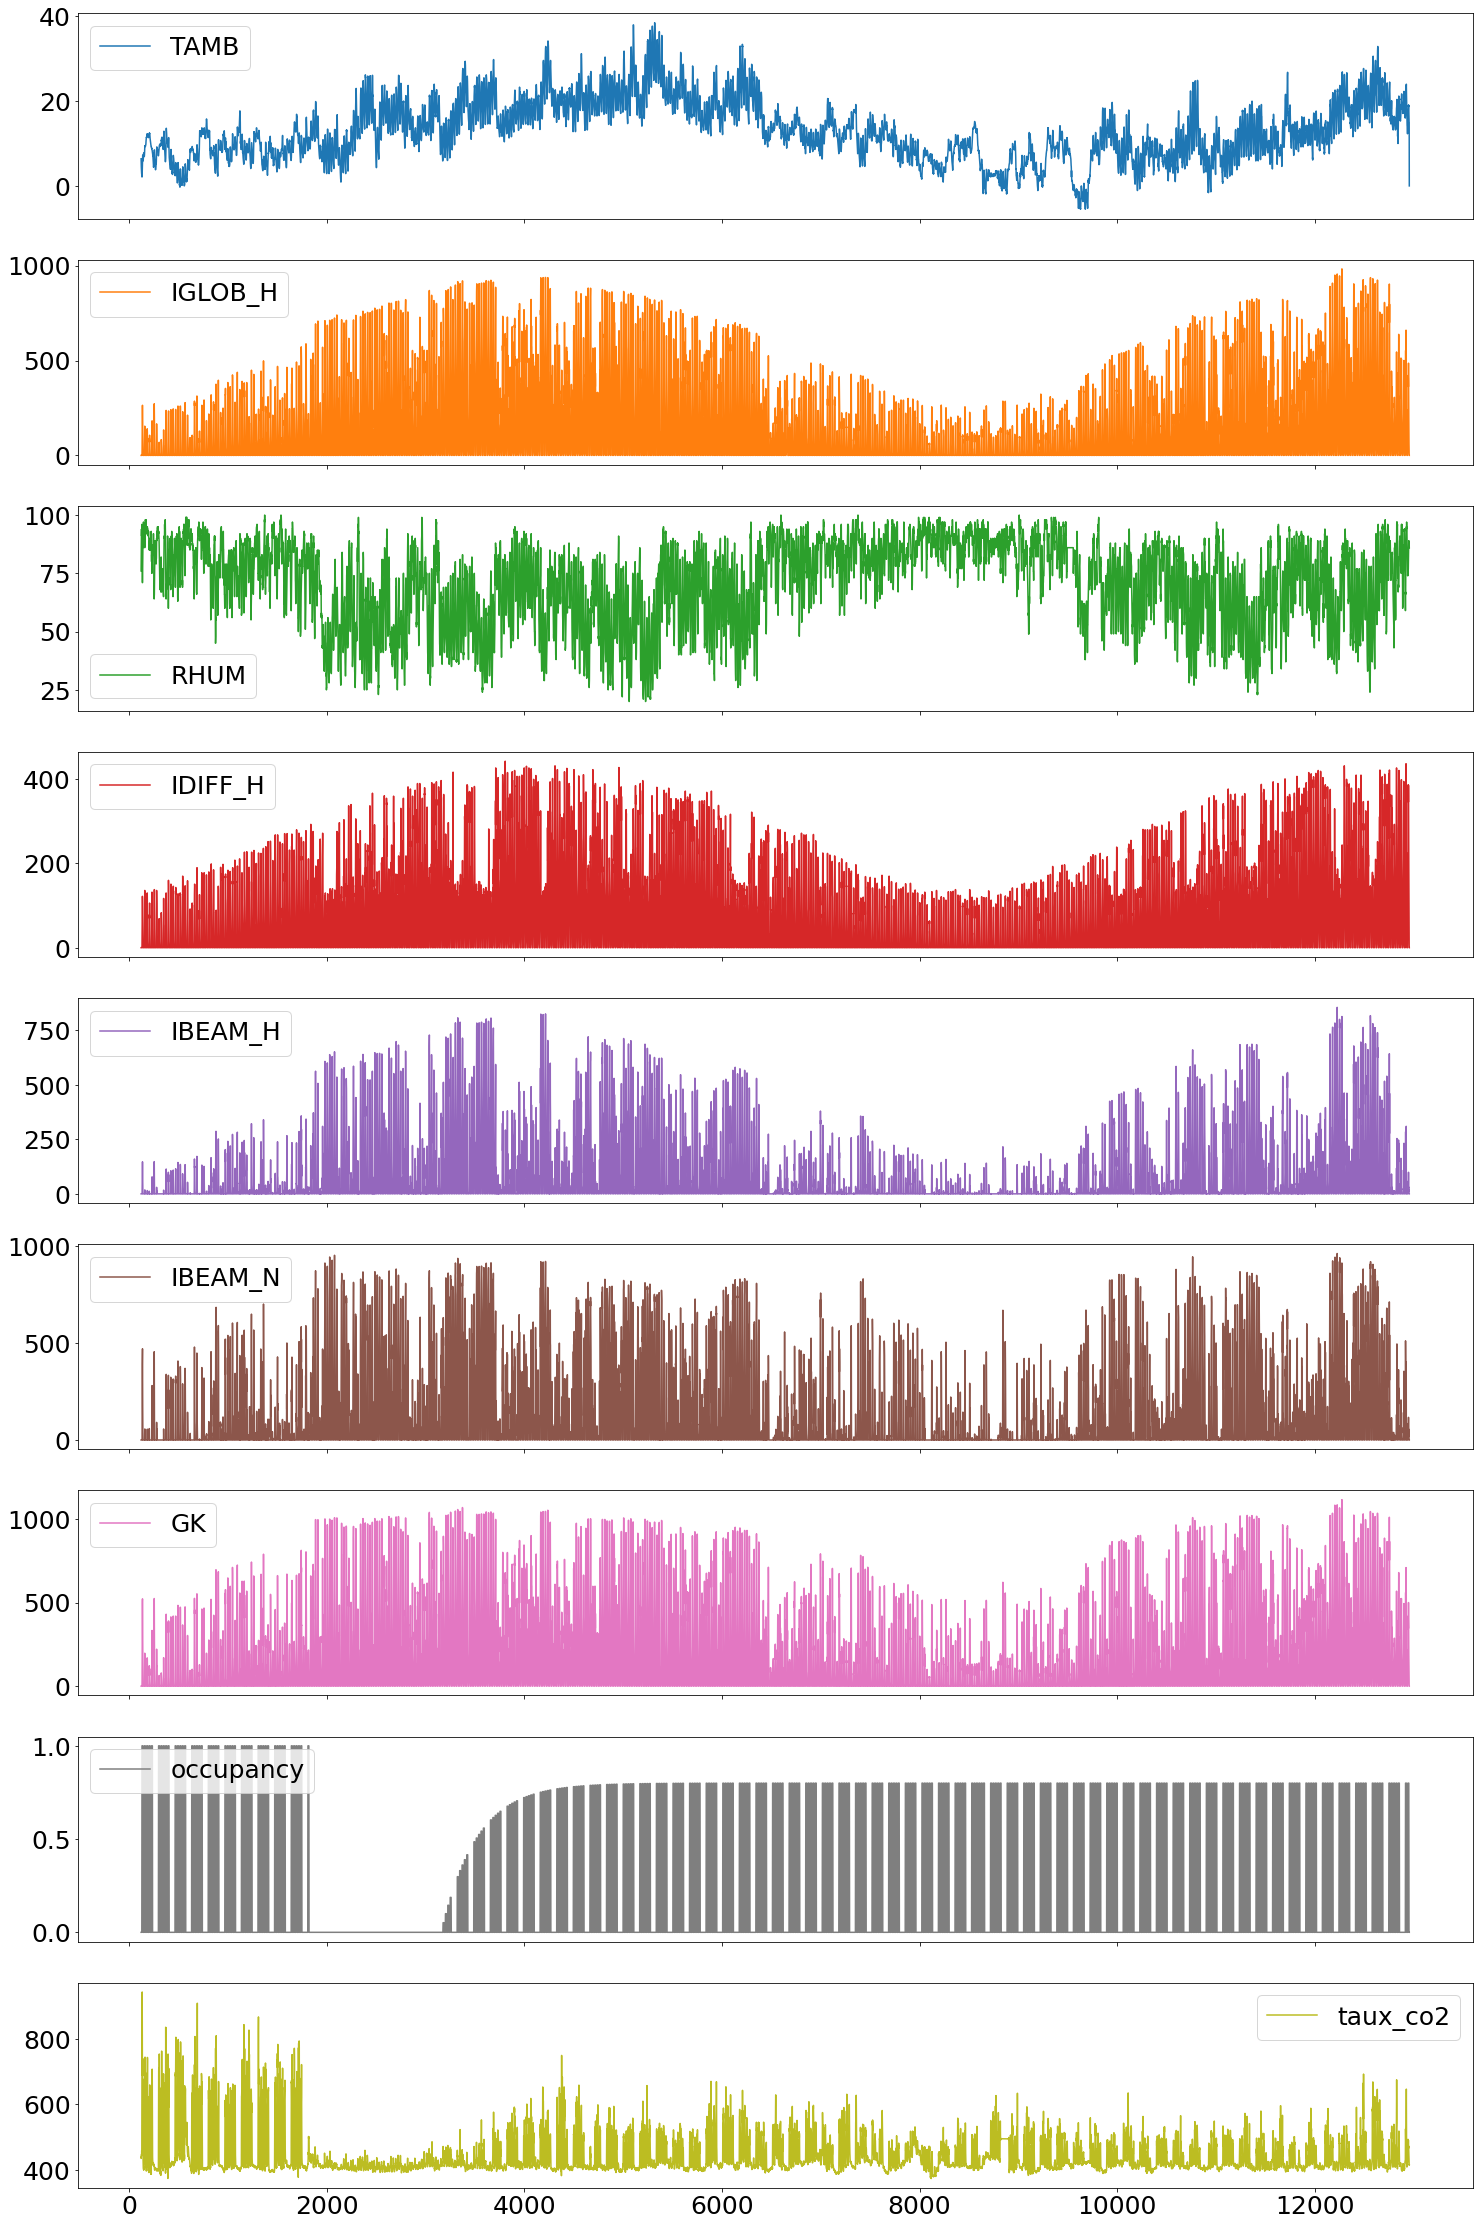

In [54]:
_ = df[[*OzeDataset.input_columns, *OzeDataset.target_columns]].plot(subplots=True, figsize=(25, 40))

In [26]:
df[OzeDataset.input_columns]

,TAMB,IGLOB_H,RHUM,IDIFF_H,IBEAM_H,IBEAM_N,GK,occupancy
6577,15.2,0.0,81.0,0.0,0.0,0.0,0.0,0.0
6578,15.0,0.0,83.0,0.0,0.0,0.0,0.0,0.0
6579,14.8,0.0,87.0,0.0,0.0,0.0,0.0,0.0
6580,14.5,0.0,87.0,0.0,0.0,0.0,0.0,0.0
6581,14.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
7315,16.3,0.0,86.0,0.0,0.0,0.0,0.0,0.0
7316,15.9,0.0,89.0,0.0,0.0,0.0,0.0,0.0
7317,15.8,0.0,90.0,0.0,0.0,0.0,0.0,0.0
7318,15.1,0.0,91.0,0.0,0.0,0.0,0.0,0.0


In [55]:
OzeDataset.target_columns = ['taux_co2']

In [56]:
train_mod = sm.tsa.statespace.SARIMAX(endog=df[df["val"] == False][OzeDataset.target_columns], exog=df[df["val"] == False][OzeDataset.input_columns])

/home/mrmojo/Code/these/smcl/.env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/mrmojo/Code/these/smcl/.env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [57]:
fit_res = train_mod.fit(disp=False, maxiter=250)

In [65]:
test_mod = sm.tsa.statespace.SARIMAX(endog=df[df["val"] == True][OzeDataset.target_columns], exog=df[df["val"] == True][OzeDataset.input_columns])
test_res = test_mod.filter(fit_res.params)

/home/mrmojo/Code/these/smcl/.env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/mrmojo/Code/these/smcl/.env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [92]:
predict = test_res.get_prediction(dynamic=24*3)

In [93]:
predict_ci = predict.conf_int()

In [94]:
predict_ci

,lower taux_co2,upper taux_co2
8712,-6272.663050,6232.146119
8713,392.175866,483.988497
8714,391.593276,483.405907
8715,387.708118,479.520749
8716,388.682495,480.495125
...,...,...
12954,-2395.576059,3215.837988
12955,-2402.985482,3209.028393
12956,-2406.670417,3205.943188
12957,-2407.568557,3205.644683


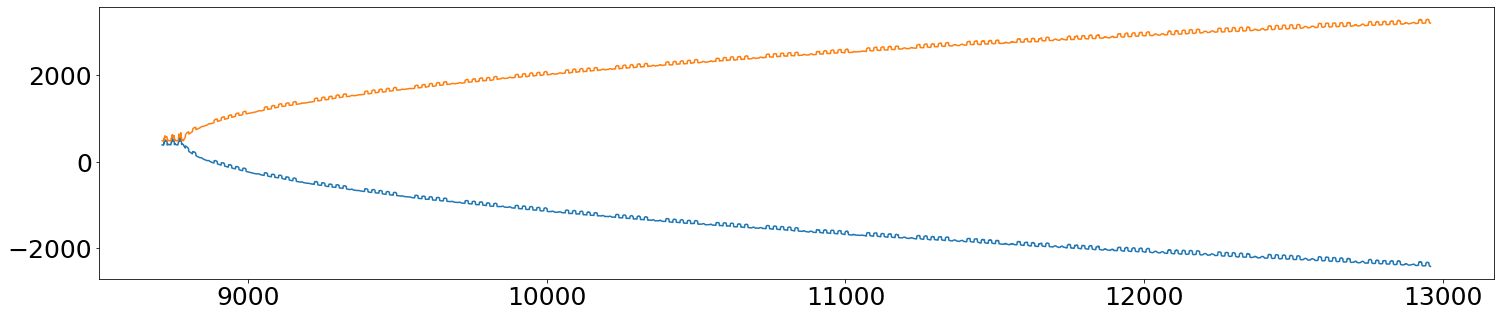

In [95]:
plt.plot(predict_ci[1:])

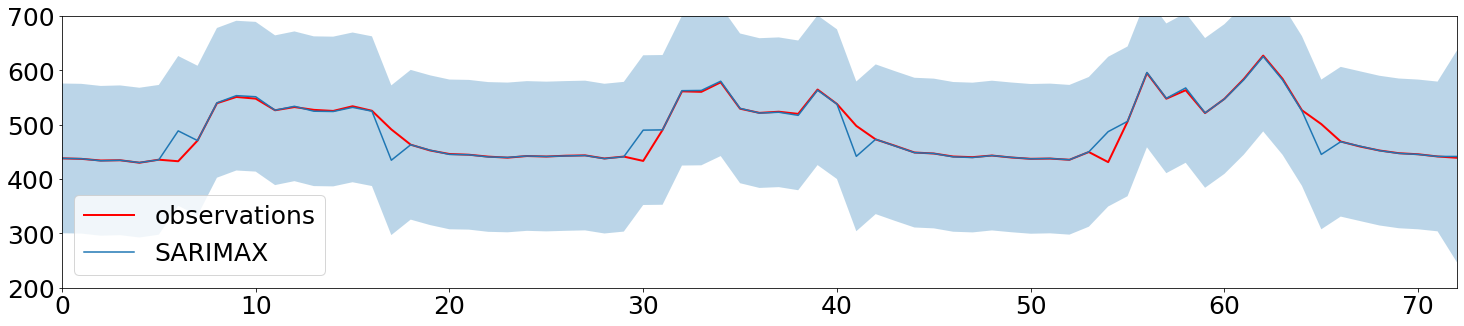

In [101]:
T = df[df["val"] == True][OzeDataset.target_columns].shape[0]
plt.plot(np.arange(T), df[df["val"] == True][OzeDataset.target_columns].values, lw=2, label='observations', c='red')
plot_range(predict_ci[1:].values, label='SARIMAX')

plt.xlim((0, 24*3))
plt.ylim(200, 700)
plt.legend()
plt.show()

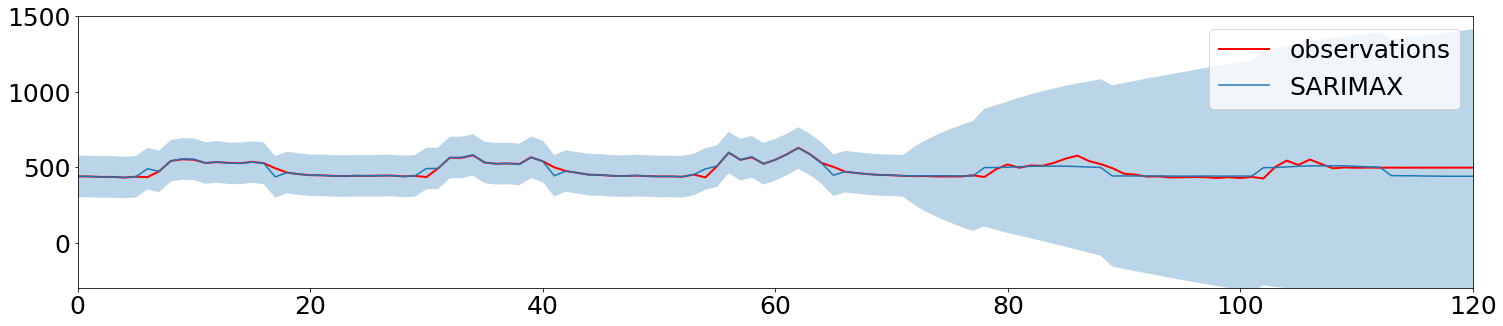

In [99]:
T = df[df["val"] == True][OzeDataset.target_columns].shape[0]
plt.plot(np.arange(T), df[df["val"] == True][OzeDataset.target_columns].values, lw=2, label='observations', c='red')
plot_range(predict_ci[1:].values, label='SARIMAX')

plt.xlim((0, 24*(3+2)))
plt.ylim(-300, 1500)
plt.legend()
plt.show()

### Define dataloaders

In [ ]:
dataloader_train = DataLoader(
    OzeDataset(df, T=T, val=False),
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=True
)

dataloader_val = DataLoader(
    OzeDataset(df, T=T, val=True),
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False
)

## Model

In [ ]:
# We combine a generic input model (3 layered GRU) with a smc layer
class SMCM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        
        self.input_model = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=3)
        self.smcl = SMCL(input_size=hidden_size,
                         hidden_size=hidden_size,
                         output_size=output_size,
                         n_particles=100,
                        )
        
    def forward(self, u, y=None):
        u_tilde = self.input_model(u)[0]
        y_hat = self.smcl(u_tilde, y)
        return y_hat
    
    def uncertainty_estimation(self, u, y=None, p=0.05, observation_noise=True):
        u_tilde = self.input_model(u)[0]
        return self.smcl.uncertainty_estimation(u_tilde,
                                                  y=y,
                                                  p=p,
                                                  observation_noise=observation_noise)

In [ ]:
D_IN = len(OzeDataset.input_columns)
D_OUT = len(OzeDataset.target_columns)

model = SMCM(input_size=D_IN, hidden_size=D_EMB, output_size=D_OUT)

## Traditional training

### Define training steps

In [ ]:
class LitClassicModule(pl.LightningModule):
    def __init__(self, model, lr=1e-3):
        super().__init__()
        self.model = model
        self.lr = lr
        self.criteria = torch.nn.MSELoss()
    
    def training_step(self, batch, batch_idx):
        u, y = batch
        u = u.transpose(0, 1)
        y = y.transpose(0, 1)

        y_hat = self.model(u)
        loss = self.criteria(y, y_hat)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

### Train

In [ ]:
train_model = LitClassicModule(model, lr=1e-2)
trainer = pl.Trainer(max_epochs=EPOCHS, gpus=1, callbacks=[bar])
trainer.fit(train_model, dataloader_train)

# Save pretrain parameters
params_pretrain = copy.deepcopy(model.state_dict())

# Compute cost (default to MSE) mean and variance
losses = compute_cost(model, dataloader_val)
print(f"MSE:\t{losses.mean():.2f} \pm {losses.var():.4f}")

### Plot predictions

In [ ]:
plot_daily_predictions(model, dataloader_train)

In [ ]:
plot_daily_predictions(model, dataloader_val)

## SMC calibration

### Define training steps

In [ ]:
class LitSMCModule(pl.LightningModule):
    def __init__(self, model, lr=1e-3):
        super().__init__()
        self.model = model
        self.lr = lr
        self.MSE = torch.nn.MSELoss()
        
        
        self._SGD_idx = 1
    
    def training_step(self, batch, batch_idx):
        u, y = batch
        u = u.transpose(0, 1)
        y = y.transpose(0, 1)
        # Forward pass
        self.model(u=u, y=y)
        # Compute loss
        loss = self.model.smcl.compute_cost(y=y)
        # Update Sigma_x
        gamma = 1 / np.sqrt(self._SGD_idx)
        self.model.smcl.sigma_x2 = (1 - gamma)*self.model.smcl.sigma_x2 + gamma*self.model.smcl.compute_sigma_x()
        self.model.smcl.sigma_y2 = (1 - gamma)*self.model.smcl.sigma_y2 + gamma*self.model.smcl.compute_sigma_y(y=y)
        self._SGD_idx += 1
        return loss
   
    def configure_optimizers(self):
        # We only optimize SMCL parameters
        optimizer = torch.optim.Adam(self.model.smcl.parameters(), lr=self.lr)
        return optimizer

### Train

In [ ]:
# Train model
train_model = LitSMCModule(model, lr=3e-3)
trainer = pl.Trainer(max_epochs=EPOCHS_SMCN, gpus=1, callbacks=[bar])
trainer.fit(train_model, dataloader_train)

# Compute MSE mean and variance
losses = compute_cost(model, dataloader_val)
print(f"MSE:\t{losses.mean():.2f} \pm {losses.var():.4f}")

# Compute PI metrics
picp, mpiw = pi_metrics(model.uncertainty_estimation, dataloader_val)
print(f"PICP:\t{picp.mean():.2f} \pm {picp.var():.4f}\nMPIW:\t{mpiw.mean():.3f} \pm {mpiw.var():.4f}")

### Evaluate predictions

In [ ]:
# Generate inference sample
idx = np.random.randint(0, len(dataloader_val.dataset))
u, y = dataloader_val.dataset[idx]
u = u.unsqueeze(1)
y = y.unsqueeze(1)

# Set target idx for vialization (0 for CO2 levels)
idx_out = 0

#### Traditional inference with new weights

In [ ]:
# Plot inference with original model, print cost
model.N=1
plot_daily_predictions(model, dataloader_val)
losses = compute_cost(model, dataloader_val, criteria=torch.nn.L1Loss(reduction='none'))
print(f"{losses.mean():.2f} \pm {losses.var():.4f}")
model.N=N

#### Smoother predictions

In [ ]:
with torch.no_grad():
    netout = model(u=u,
                   y=y)

netout = model.smcl.smooth_pms(netout, model.smcl.I).numpy()

plot_range(netout[:, 0, :, idx_out], label='predictions')
plt.plot(y[:, 0, idx_out], lw=3, label='observations')
plt.legend()
plt.show()

#### Predictions at $t+1$

In [ ]:
start_day = 0
end_day = start_day+7
day_hide = 0
tick_step = 12
burnin = 0
netout_smc, y_scaled = boxplotprediction(model, dataloader_val, u, y, day_hide=day_hide, burnin=burnin)

netout_smc = netout_smc[24*start_day:24*end_day]
y_scaled = y_scaled[24*start_day:24*end_day]

plt.boxplot(netout_smc.T,
            positions=np.arange(netout_smc.shape[0])-0.2,
            sym="",
            whis=(0, 100), # 95% already selected here
            widths=0.3,
            patch_artist=True,
            boxprops=dict(facecolor="skyblue"))
plt.plot(netout_smc.mean(-1), lw=5, label='SMCL')


plt.plot(y_scaled, "--", lw=6, label='Observations', zorder=100, color="#2ca02c")

plt.legend()
# plt.xticks(np.arange(burnin, T+1-burnin, 24), np.arange(burnin, T+1-burnin, 24))
plt.xticks(np.arange(0, (end_day - start_day)*24+1, tick_step), np.arange(0, (end_day - start_day)*24+1, tick_step)+start_day*24)
plt.xlabel("time (hour)")
# plt.ylabel("humidity (percent)")
plt.ylabel("CO2 (ppm)")
plt.show()

In [ ]:
start_day = 3
end_day = start_day+3
day_hide = start_day+1
tick_step = 12

netout_smc, y_scaled = boxplotprediction(model, dataloader_val, u, y, day_hide=day_hide, burnin=0)

netout_smc = netout_smc[24*start_day:24*end_day]
y_scaled = y_scaled[24*start_day:24*end_day]


plt.boxplot(netout_smc.T,
            positions=np.arange(netout_smc.shape[0])-0.2,
            sym="",
            whis=(0, 100), # 95% already selected here
            widths=0.3,
            patch_artist=True,
            boxprops=dict(facecolor="skyblue"))
plt.plot(netout_smc.mean(-1), lw=5, label='SMCL')


plt.plot(y_scaled, "--", lw=6, label='Observations', zorder=100)

plt.legend()
# plt.xticks(np.arange(burnin, T+1-burnin, 24), np.arange(burnin, T+1-burnin, 24))
plt.xticks(np.arange(0, (end_day - start_day)*24+1, tick_step), np.arange(0, (end_day - start_day)*24+1, tick_step)+start_day*24)
plt.xlabel("time (hour)")
# plt.ylabel("humidity (percent)")
plt.ylabel("CO2 (ppm)")
plt.show()

#### Plot particules with $\alpha \propto \omega$

We plot each trajectory, with a transparancy setting proportionnal to their associated weight. This graph aims at visualizing particle degenerecence.

In [ ]:
with torch.no_grad():
    netout = model(u=u,
                   y=y)

netout = model.smcl.smooth_pms(netout, model.smcl.I)

batch_idx = 0

netout = netout[:, batch_idx, :, idx_out].numpy()
w = model.smcl.w[batch_idx]
# w = torch.softmax(w, dim=0)
w = w.numpy()

# plt.plot(y[:, batch_idx].squeeze().numpy(), '--', lw=3, alpha=0.6, c='green')
for trajectory, weight in zip(netout.T, w):
    plt.plot(trajectory, alpha=weight, c='blue')